In [162]:
# !pip install bootstrapped
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
import numpy as np
import numpy as np
from scipy.stats import pearsonr
import json
from pprint import pprint
from bson.json_util import dumps
from pprint import pprint
from dateutil import parser
from dateutil import parser
from datetime import datetime, timedelta
import csv
sns.set()
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
connection = MongoClient("ds159025.mlab.com", 59025)
db = connection["markantstudy"]
db.authenticate("markant","emotion2019")
db.collection_names()

/Users/darts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.
  after removing the cwd from sys.path.


['visGroupCounts',
 'uncertainty2beliefs',
 'system.indexes',
 'newconfbias',
 'uncertaintybeliefs',
 'uncertainty3beliefs',
 'newconfbiasmturks',
 'userresponses']

In [3]:
col = db.newconfbiasmturks
print(col.find().count())

551


/Users/darts/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  


In [163]:
with open("batch1.csv") as csvFile:
    batch1 = [i for i in csv.DictReader(csvFile)]
with open("batch2.csv") as csvFile:
    batch2 = [i for i in csv.DictReader(csvFile)]

In [164]:
allBatches = batch1 + batch2

In [167]:
tokenWorkTime = {o["Answer.surveycode"]:int(o["WorkTimeInSeconds"]) for o in allBatches}

In [168]:
tokenWorkTime

{'PUhRawzc': 1440,
 'zrtzzMMq': 854,
 'k8cfnOrI': 3174,
 '4qCMLPwT': 3160,
 'NO3T9tQi': 982,
 '6VqNTTBM': 1628,
 '8nQE5rIn': 1975,
 'wswqBWIU': 463,
 'ScMYgxZ2': 2059,
 'HwkNUz4u': 838,
 'fNtYi8bE': 1103,
 'yl990Uii': 1332,
 's4chhFf7': 3057,
 'eO823cco': 3048,
 'UVR4S5vg': 3328,
 'lxx3VEWp': 2374,
 'CqSST6n1': 2462,
 '3sw8hFsd': 3383,
 'B0wa30cz': 1007,
 'UzejMK3l': 3392,
 'A61QXn4N': 813,
 'mNxXskAm': 1103,
 '1zPGOn0U': 592,
 'ib8fhchj': 1083,
 'AuVxWJUK': 1264,
 'dEQk6Mhi': 1263,
 '9MtrIqGc': 1441,
 'Aono0iKM': 1367,
 'ksVch4FK': 1741,
 'WFQzPEni': 1907,
 'ufBsgtDi': 1303,
 'TTDRaFXo': 917,
 'ijkssXGV': 3528,
 'pXKKrY4a': 1085,
 'DMyXslsX': 1190,
 'vl54HL1H': 676,
 'uazFkSdf': 712,
 'njlWCr0M': 797,
 'XNxr6n4F': 1174,
 '8RU3nE0z': 2267,
 '7oe2yDye': 1511,
 'eUwpFKis': 1896,
 'O6kjKgbS': 2156,
 'gh6skqNa': 1396,
 'nM3fPbbZ': 3264,
 'nI2ETlF8': 3524,
 'isp2RIed': 1010,
 'IZHN8r6o': 382,
 'nhFoK1KX': 764,
 'FQ9V91eN': 1838,
 'uQuyrdbj': 890,
 'WqmI8K2Y': 440,
 'X5ZRTuXu': 3152,
 'wBooC

In [ ]:
col.count_documents({"responses.15":{"$exists":True}})

In [71]:
def getTidyDf(col):
    userResponses =  list(col.find({"responses":{"$size":30}}))
    visGroupCount = {"line":0,"hop":0,"band":0}
    outputData = []
    for doc in userResponses:
        usertoken = doc["usertoken"]
        userData = []
        faultyData = False
        visGroupCount[doc["visGroup"]]+=1
        for i in range(0,30,3):
            try:
                varIndex = int(i/3)
                task = doc["responses"][i:i+3]
                draw1 = task[0]
                draw2 = task[2]
                if draw1["state"] == "draw1" and draw2["state"] == "draw2":
                    for response in [draw1,draw2]:
                        if not "uncertainty" in response:
                            response["uncertainty"] = [float(response["belief"]),float(response["belief"])]
                        if varIndex <= 4:
                            visGroup = "scatter"
                        else:
                            visGroup = doc["visGroup"]
                        d = {
                          "belief" : float(response["belief"]),
                          "uncertaintyLower" : float(response["uncertainty"][0]),
                          "uncertaintyUpper" : float(response["uncertainty"][1]),
                          "startTime" : int(response["startTime"]),
                          "endTime" : int(response["endTime"]),
                          "vars" : "_".join([var for var in response["variables"]]),
                          "varIndex": varIndex,
                          "usertoken" : usertoken,
                          "state" : response["state"],
                          "visGroup":visGroup
                        }
                        userData.append(d)
                else:
                    faultyData = True
            except Exception as e:
                print(e)
                faultyData = True
        if not faultyData:
            outputData += userData
        else:
            print(len(doc["responses"]))
            pprint(doc)
            print("--------")
    print(visGroupCount)
    df = pd.DataFrame.from_records(outputData)
    return df

In [73]:
df = getTidyDf(col)

30
{'__v': 0,
 '_id': ObjectId('5e642bf27e302d0017d98fbf'),
 'attention': {'freeform_1': 'Call the interviewer to reschedule for another '
                             'appointment.',
               'freeform_2': 'Wait and ask for the cashier.'},
 'bandTestErrors': {'errorCount': '2', 'startTime': '1583623497481'},
 'date': datetime.datetime(2020, 3, 7, 23, 19, 14, 32000),
 'lineTestErrors': {'errorCount': '2', 'startTime': '1583623218351'},
 'participantGroup': 'mturk',
 'postquestionnaire': {'active': '5',
                       'afraid': '1',
                       'alert': '4',
                       'ashamed': '1',
                       'attentive': '5',
                       'determined': '5',
                       'economic': '5',
                       'hostile': '1',
                       'inspired': '4',
                       'nervous': '2',
                       'social': '5',
                       'upset': '2'},
 'prequestionnaire': {'age': '30',
                    

                'uncertainty': ['-1', '1'],
                'variables': ['Government spending', 'Budget deficit']},
               {'endTime': '1583789508739',
                'startTime': '1583789482497',
                'state': 'dataViz',
                'variables': ['Income tax rate', 'Poverty rate']},
               {'belief': '-0.39839138364643345',
                'endTime': '1583789523002',
                'startTime': '1583789510438',
                'state': 'draw2',
                'uncertainty': ['-1', '1'],
                'variables': ['Income tax rate', 'Poverty rate']},
               {'belief': '0.8364073749211223',
                'endTime': '1583789842219',
                'startTime': '1583789834611',
                'state': 'draw1',
                'uncertainty': ['0.08397750339761156', '1'],
                'variables': ['Temperature', 'Crime rate']},
               {'endTime': '1583789847196',
                'startTime': '1583789843762',
                'stat

                'endTime': '1583791942172',
                'startTime': '1583791938386',
                'state': 'draw2',
                'uncertainty': ['-0.25303569666038855', '1'],
                'variables': ['Government spending', 'Budget deficit']}],
 'usertoken': '1738cPZm',
 'variables1': [['Weight', 'Price'],
                ['Yearly income', 'Height'],
                ['Temperature', 'Sales of Mittens'],
                ['Exercise amount', 'Body weight'],
                ['Temperature', 'Crime rate']],
 'variables2': [['Income tax rate', 'Poverty rate'],
                ['Vaccination rate', 'Rate of illness'],
                ['Immigrant population', 'Economic growth'],
                ['Labor union participation', 'Corporate profits'],
                ['Government spending', 'Budget deficit']],
 'visGroup': 'band'}
--------
30
{'__v': 0,
 '_id': ObjectId('5e66baf57ddffb00172024ca'),
 'attention': {'freeform_1': 'Use some medications and still head out.',
               'f

In [189]:
def getUserInfo(col):
    userResponses =  list(col.find({"responses":{"$size":30}}))
    outputData = []
    for doc in userResponses:
        usertoken = doc["usertoken"]
        attention1 = doc["attention"]["freeform_1"]
        attention2 = doc["attention"]["freeform_2"]
        bandTestErrorCount = doc["bandTestErrors"]["errorCount"]
        lineTestErrorCount = doc["lineTestErrors"]["errorCount"]
        startTime = doc["responses"][0]['startTime']
        endTime = doc["responses"][-1]["endTime"]
        startTime = datetime.fromtimestamp(int(startTime)/1000)
        endTime = datetime.fromtimestamp(int(endTime)/1000)
#         startTime = startTime-timedelta(hours=5)
        minutes = (endTime - startTime)
        taskMinutes = minutes.seconds / 60
        totalMinutes = tokenWorkTime[usertoken]/60 if usertoken in tokenWorkTime else "N/A" 
#         pprint(doc)
        d = {
            "usertoken" : usertoken,
            "attention1" : attention1,
            "attention2" : attention2,
            "bandTestErrorCount": bandTestErrorCount,
            "lineTestErrorCount": lineTestErrorCount,
            "response duration" : taskMinutes,
            "total duration (mturk)" : totalMinutes,
            "count responses" : len(doc["responses"])
        }
        outputData.append(d)
    return pd.DataFrame.from_records(outputData)

In [192]:
userInfo = getUserInfo(col)
userInfo.to_csv("userInfo.csv")

In [57]:
len(df.usertoken.unique())

279

In [74]:
df.to_csv("mturk_all.csv")

In [92]:
df= pd.read_csv("mturk_all.csv")

In [12]:
df.groupby(["usertoken","visGroup"]).count()

belief  endTime  startTime  state  uncertaintyLower  \
usertoken visGroup                                                        
08zKHo8E  band          10       10         10     10                10   
          scatter       10       10         10     10                10   
09rIYGes  line          10       10         10     10                10   
          scatter       10       10         10     10                10   
0FGSpKJI  band          10       10         10     10                10   
          scatter       10       10         10     10                10   
0RciEixE  band          10       10         10     10                10   
          scatter       10       10         10     10                10   
0Xp9yMo0  hop           10       10         10     10                10   
          scatter       10       10         10     10                10   
0ZjAFmDL  line          10       10         10     10                10   
          scatter       10       10         10     10                10   
1738cPZm  band          10       10         10     10                10   
          scatter        9       10         10     10                10   
1TXFgBI8  band          10       10         10     10                10   
          scatter       10       10         10     10                10   
1WvItSyH  band          10       10         10     10                10   
          scatter       10       10         10     10                10   
1zPGOn0U  band          10       10         10     10                10   
          scatter       10       10         10     10                10   
2l9rp9wj  hop           10       10         10     10                10   
          scatter       10       10         10     10                10   
2tJSMLu0  band          10       10         10     10                10   
          scatter       10       10         10     10                10   
309BSuF3  band          10       10         10     10                10   
          scatter       10       10         10     10                10   
37nszq7b  line          10       10         10     10                10   
          scatter       10       10         10     10                10   
3ZnVe88s  line          10       10         10     10                10   
          scatter       10       10         10     10                10   
...                    ...      ...        ...    ...               ...   
wswqBWIU  band          10       10         10     10                10   
          scatter       10       10         10     10                10   
wu3s5097  band          10       10         10     10                10   
          scatter       10       10         10     10                10   
wwguUNk7  line          10       10         10     10                10   
          scatter       10       10         10     10                10   
xlYUSARn  hop           10       10         10     10                10   
          scatter       10       10         10     10                10   
y5KS876z  hop           10       10         10     10                10   
          scatter       10       10         10     10                10   
y7eQh4WX  line          10       10         10     10                10   
          scatter       10       10         10     10                10   
yCHNp1SD  band          10       10         10     10                10   
          scatter       10       10         10     10                10   
yfb03Jcw  band          10       10         10     10                10   
          scatter       10       10         10     10                10   
yk4rkAc3  hop           10       10         10     10                10   
          scatter       10       10         10     10                10   
yl990Uii  hop           10       10         10     10                10   
          scatter       10       10         10     10                10   
ypYQGBqY  band          10       10         1

In [23]:
test = list(col.find({"usertoken":"ksVch4FK"}))[0]

In [28]:
for i in test["responses"]:
    pprint(i)
    pprint("----")

{'belief': '0.7802182161473821',
 'endTime': '1583623553993',
 'startTime': '1583623533560',
 'state': 'draw1',
 'uncertainty': ['0.4529354695986829', '1'],
 'variables': ['Temperature', 'Crime rate']}
'----'
{'endTime': '1583623568144',
 'startTime': '1583623556901',
 'state': 'dataViz',
 'variables': ['Temperature', 'Crime rate']}
'----'
{'belief': '0.024718496302325033',
 'endTime': '1583623575566',
 'startTime': '1583623570095',
 'state': 'draw2',
 'uncertainty': ['-0.01547085255888625', '0.06490784516353632'],
 'variables': ['Temperature', 'Crime rate']}
'----'
{'belief': '0.18962997285103267',
 'endTime': '1583623584822',
 'startTime': '1583623580725',
 'state': 'draw1',
 'uncertainty': ['0.17012801026691338', '0.20913193543515196'],
 'variables': ['Exercise amount', 'Body weight']}
'----'
{'endTime': '1583623591429',
 'startTime': '1583623587749',
 'state': 'dataViz',
 'variables': ['Exercise amount', 'Body weight']}
'----'
{'belief': '0.08487785659212688',
 'endTime': '15836235

In [39]:
df.to_csv("wenwenClass.csv")

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pymc3 as pm
from pymc3 import Model, Normal, Slice
from pymc3 import sample
from pymc3 import traceplot
from pymc3.distributions import Interpolated
from theano import as_op
import theano.tensor as tt
import numpy as np
from scipy import stats

In [43]:
def generateDataset(rho,n=100):
    r = np.array([[1, rho],[rho, 1]])
    y = np.random.multivariate_normal([0.0,0.0], r, size=n)
#     print(y)
#     y = y - np.mean(y,axis=0)
#     print(np.mean(y,axis=0))
    x = y[:,0]
    y= y[:,1]
    x = x - np.mean(x)
    y = y - np.mean(y)
    plt.scatter(x,y)
    plt.show()
    d = [{"x":i,"y":j} for i,j in zip(x,y)]
    calcRho = pearsonr(x,y)
    return({"data":d,"N":n,"rho":rho,"calcRho":calcRho[0]})

In [75]:
df.head()

,belief,endTime,startTime,state,uncertaintyLower,uncertaintyUpper,usertoken,varIndex,vars,visGroup
0,-0.654735,1583619187487,1583619170013,draw1,-0.702483,-0.606987,ib8fhchj,0,Vaccination rate_Rate of illness,scatter
1,0.810075,1583619205534,1583619193870,draw2,0.777463,0.842687,ib8fhchj,0,Vaccination rate_Rate of illness,scatter
2,0.511726,1583619223790,1583619206887,draw1,0.480292,0.543161,ib8fhchj,1,Government spending_Budget deficit,scatter
3,-1.000000,1583619234045,1583619228214,draw2,-1.000000,-1.000000,ib8fhchj,1,Government spending_Budget deficit,scatter
4,0.797785,1583619246430,1583619235566,draw1,0.731276,0.864295,ib8fhchj,2,Immigrant population_Economic growth,scatter


In [133]:
diffDfs = []
for usertoken in df["usertoken"].unique():
    userData = df[df["usertoken"]==usertoken]
    draw1 = userData[userData["state"]=="draw1"]
    draw2 = userData[userData["state"]=="draw2"]
    vars_ = draw1["vars"]
    usertoken = df["usertoken"]
    visGroup = draw1.visGroup
    diffs = np.array(draw1.belief) - np.array(draw2.belief)
    diffDf = pd.DataFrame()
    diffDf["vars"] = vars_
    diffDf["usertoken"] = usertoken
    diffDf["visGroup"] = visGroup
    diffDf["diffs"] = diffs
    diffDfs.append(diffDf)

In [134]:
allDiffDf = pd.concat(diffDfs)

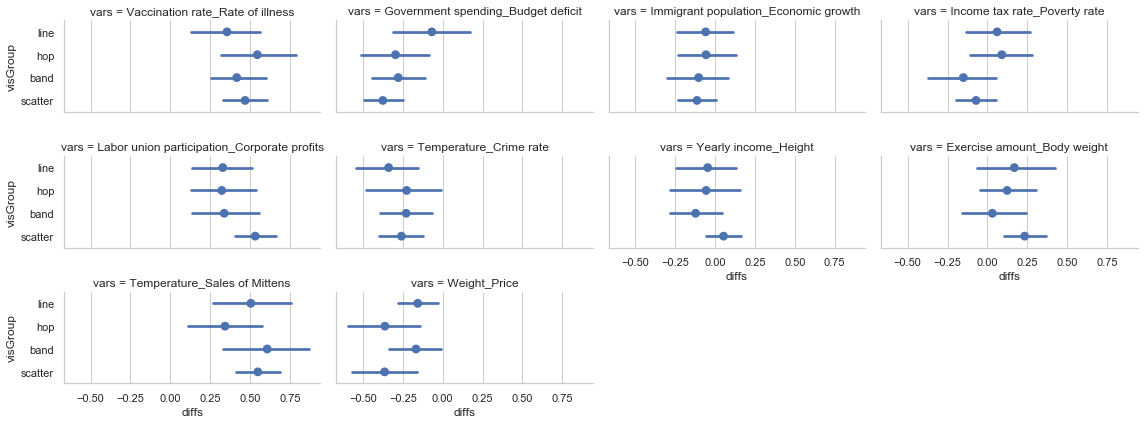

In [136]:
sns.catplot(col="vars",col_wrap=4,x="diffs",y="visGroup",data=allDiffDf,kind="point",join=False,aspect=2,height=2)

In [127]:
uncertaintyDiffDfs = []
for usertoken in df["usertoken"].unique():
    userData = df[df["usertoken"]==usertoken]
    draw1 = userData[userData["state"]=="draw1"]
    draw2 = userData[userData["state"]=="draw2"]
    vars_ = draw1["vars"]
    usertoken = df["usertoken"]
    visGroup = draw1.visGroup
    draw1UncertaintySize = np.abs(np.array(draw1.uncertaintyUpper) - np.array(draw1.uncertaintyLower))
    draw2UncertaintySize = np.abs(np.array(draw2.uncertaintyUpper) - np.array(draw2.uncertaintyLower))
    diffs = draw1UncertaintySize - draw2UncertaintySize
    diffDf = pd.DataFrame()
    diffDf["vars"] = vars_
    diffDf["usertoken"] = usertoken
    diffDf["visGroup"] = visGroup
    diffDf["uncertainty size difference"] = diffs
    uncertaintyDiffDfs.append(diffDf)

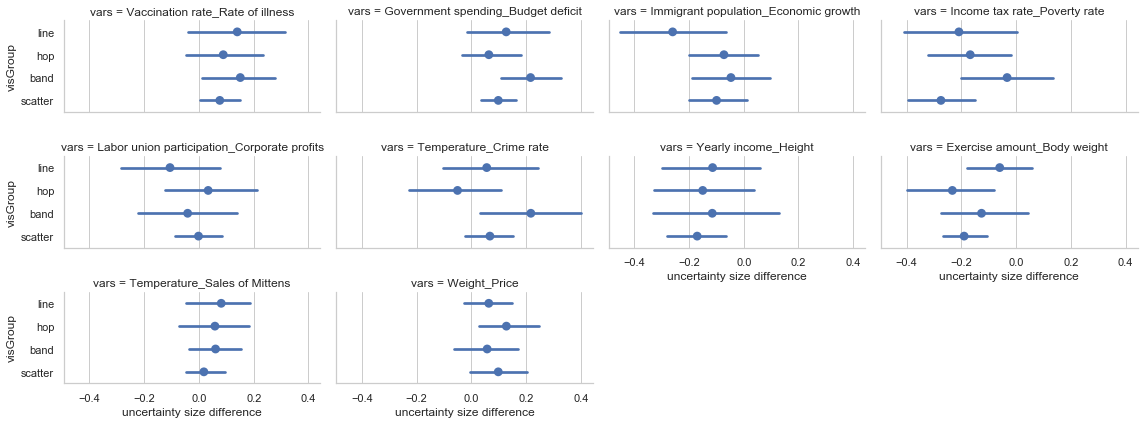

In [137]:
allUncertaintyDiff = pd.concat(uncertaintyDiffDfs)

sns.catplot(col="vars",col_wrap=4,x="uncertainty size difference",y="visGroup",data=allUncertaintyDiff,kind="point",join=False,aspect=2,height=2)